In [1]:
import folium
import geocoder
import foursquare as fs
import numpy as np
import pandas as pd
import seaborn as sns
from foursquare_api_tools import foursquare_api_tools as ft  # from https://github.com/dacog/foursquare_api_tools

# Capstone Project - The Battle of Neighborhoods (Week 1 + 2)
## Finding the best neighborhood for my new Japanese restaurant
*This notebook contains my submission for Capstone Project week 1 and 2 of the Coursera course 'Applied Data Science Capstone'.*

## Introduction
As a restaurant owner I would like to open a Japanese restaurant in Toronto, Canada. As I would like to maximize my profits, I am looking for a neighborhood that would meet the following requirements:

* have a relatively high population;
* have a low crime rate;
* have a low number of Japanese restaurants.

In order to determine the best neighborhood to open a new Japanese restaurant, we could use data science for supporting this business decision: The business problem is to find the best neighborhood to open a Japanese restaurant in terms of maximizing profits. Important assumptions I make are 1) a high population leads to more profits, and 2) a high crime rate leads to less profits. more people would lead to more business and more crime leads to less business).

### Target audience
Even thought this project is tailored to (potentially new) restaurant owners, the target audience is anyone who is interested in opening a business anywhere in the world. The techniques used here could also be applied to various other businesses (coffee shops, clothing stores, supermarkets etc.) and locations. Given that data is available, the sky is the limit. Combining data sources and datasets would lead to a even more comprehensive analysis.

## Data
Since we would like to determine the best location for the restaurant using data science, one of the first steps is to determine what data we need, what data is available, and how we could use the available data to solve our business problem. Hereafter, I will describe the data that is available and that I would like to use to determine which neighborhood best fulfills the listed requirements above.

### High population / low crime rate
Data about the population of Toronto, Canada is readily available. However, as we are interested in the population per neighborhood, this data is less easy to find. The Toronto Police shares [data on crimes in neighborhoods](http://data.torontopolice.on.ca/datasets/neighbourhood-crime-rates-boundary-file-) that also happens to contain data on the population of each neighborhood. Using this dataset, we can determine the numbers of crimes per neighborhood as well as account for the population (calculate crime rates) and determine the overall crime rate by extracting a new feature (i.e., taking the average of the rates for the different crimes). The dataset looks as follows and will henceforward be referred to as the crime dataset.

In [2]:
df_crime = pd.read_csv('toronto_crime.csv', sep=';')
df_crime.head(5)

,OBJECTID,Neighbourhood_Crime_Rates_Neigh,Neighbourhood_Crime_Rates_Hood_,Hood_ID,Neighbourhood,Assault_Rate_2018,AutoTheft_Rate_2018,BreakandEnter_Rate_2018,Robbery_Rate_2018,TheftOver_Rate_2018,Homicide_Rate_2018,Population
0,1,Yonge-St.Clair,97,97,Yonge-St.Clair,1912.8,2163.7,721.2,595.8,94.1,0.0,3189
1,2,York University Heights,27,27,York University Heights,375.4,62.6,141.4,40.8,5.4,2.7,36764
2,3,Lansing-Westgate,38,38,Lansing-Westgate,1923.5,214.8,507.7,400.3,58.6,0.0,10242
3,4,Yorkdale-Glen Park,31,31,Yorkdale-Glen Park,696.5,153.6,307.1,192.0,71.3,11.0,18233
4,5,Stonegate-Queensway,16,16,Stonegate-Queensway,576.4,184.6,184.6,162.1,18.0,0.0,22207


### Restaurant data
I would like to use data from Foursquare to determine whether a neighborhood already contains a Japanese restaurant or not, and if so how many. Using this location data, I can determine whether the competition would probably be fierce in a given neighborhood or not. As my goal is to maximize profits, I should find a neighborhood that has a relatively low number of Japanese restaurants, at least per capita (per person). Of course, the assumption here is that neighborhoods with a relatively low number of Japanese restaurants result in a business opportunity to open a new Japanese restaurant.

## Methodology
### Exploratory data analysis
In order to get more insight in the crime dataset, let's perform some exploratory data analysis.

In [3]:
df_crime.columns

Index(['OBJECTID', 'Neighbourhood_Crime_Rates_Neigh',
       'Neighbourhood_Crime_Rates_Hood_', 'Hood_ID', 'Neighbourhood',
       'Assault_Rate_2018', 'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018',
       'Robbery_Rate_2018', 'TheftOver_Rate_2018', 'Homicide_Rate_2018',
       'Population'],
      dtype='object')

So the crime dataset seems to contain data on various crimes (assault, robbery, etc.) for various years (from 2014-2018). The following columns do not seem to be useful for our analysis and could be removed from the dataset:
* `OBJECTID`
* Either `Neighbourhood_Crime_Rates_Neigh` or `Neighbourhood` as to seem to be duplicates
* Either `Neighbourhood_Crime_Rates_Hood_` or `Hood_ID` as to seem to be duplicates

Let's see whether the columns are indeed duplicates, and if so remove one of them. Also remove `OBJECTID`.

In [4]:
# df_crime.duplicated does not seem to work, therefore relying on a loop
# df_crime.duplicated(['Neighbourhood_Crime_Rates_Hood_', 'Hood_ID'])
num_rows = len(df_crime)
dup_neigh = 0
dup_hood = 0
for i in range(num_rows):
    dup_neigh = (dup_neigh+1 if df_crime.Neighbourhood_Crime_Rates_Neigh[i] == df_crime.Neighbourhood[i] else dup_neigh)
    dup_hood = (dup_hood+1 if df_crime.Neighbourhood_Crime_Rates_Hood_[i] == df_crime.Hood_ID[i] else dup_hood)
if dup_neigh == num_rows:
    df_crime.drop(columns='Neighbourhood_Crime_Rates_Neigh', inplace=True)
if dup_hood == num_rows:
    df_crime.drop(columns='Neighbourhood_Crime_Rates_Hood_', inplace=True)
df_crime.drop(columns='OBJECTID', inplace=True)
df_crime.head(5)

,Hood_ID,Neighbourhood,Assault_Rate_2018,AutoTheft_Rate_2018,BreakandEnter_Rate_2018,Robbery_Rate_2018,TheftOver_Rate_2018,Homicide_Rate_2018,Population
0,97,Yonge-St.Clair,1912.8,2163.7,721.2,595.8,94.1,0.0,3189
1,27,York University Heights,375.4,62.6,141.4,40.8,5.4,2.7,36764
2,38,Lansing-Westgate,1923.5,214.8,507.7,400.3,58.6,0.0,10242
3,31,Yorkdale-Glen Park,696.5,153.6,307.1,192.0,71.3,11.0,18233
4,16,Stonegate-Queensway,576.4,184.6,184.6,162.1,18.0,0.0,22207


In [5]:
df_crime.describe()

,Hood_ID,Assault_Rate_2018,AutoTheft_Rate_2018,BreakandEnter_Rate_2018,Robbery_Rate_2018,TheftOver_Rate_2018,Homicide_Rate_2018,Population
count,140.0000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,70.5000,1003.898571,261.594286,420.752143,184.590000,66.324286,3.812857,19511.221429
std,40.5586,1081.875955,464.186501,503.727134,222.453308,100.092465,6.664238,12744.698938
min,1.0000,53.000000,9.900000,28.100000,0.000000,0.000000,0.000000,2528.000000
25%,35.7500,288.375000,76.600000,136.100000,46.325000,13.475000,0.000000,10815.000000
50%,70.5000,604.100000,136.100000,244.600000,112.000000,33.800000,0.000000,16224.500000
75%,105.2500,1265.800000,277.850000,511.600000,238.700000,72.100000,5.650000,26147.750000
max,140.0000,5829.100000,4530.900000,3322.800000,1390.300000,772.400000,38.000000,84915.000000


From the descriptive statistics we can see that every neighborhood experiences crime in some way. Some neighborhoods have less crime than others. For example, some neighborhoods experienced no robberies, others have seen 0 homicides in 2018, while others have seen multiple robberies and homicides. In order to prepare for our location data, let's add coordinates to each neighborhood.

In [6]:
# first create two columns containing NaNs
df_crime['Latitude'] = np.nan
df_crime['Longitude'] = np.nan
for x in range(num_rows):
    g = geocoder.arcgis(df_crime.Neighbourhood[x] + ', Toronto, Ontario, Canada')
    df_crime.Latitude[x] = g.lat
    df_crime.Longitude[x] = g.lng
df_crime.head(5)

//anaconda3/envs/coursera/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/envs/coursera/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Hood_ID,Neighbourhood,Assault_Rate_2018,AutoTheft_Rate_2018,BreakandEnter_Rate_2018,Robbery_Rate_2018,TheftOver_Rate_2018,Homicide_Rate_2018,Population,Latitude,Longitude
0,97,Yonge-St.Clair,1912.8,2163.7,721.2,595.8,94.1,0.0,3189,43.68883,-79.39887
1,27,York University Heights,375.4,62.6,141.4,40.8,5.4,2.7,36764,43.75997,-79.48520
2,38,Lansing-Westgate,1923.5,214.8,507.7,400.3,58.6,0.0,10242,43.75463,-79.42420
3,31,Yorkdale-Glen Park,696.5,153.6,307.1,192.0,71.3,11.0,18233,43.71388,-79.45469
4,16,Stonegate-Queensway,576.4,184.6,184.6,162.1,18.0,0.0,22207,43.63718,-79.50058


Now that we have expanded our dataset with coordinates, let's see which neighborhoods have the lowest crime rates.

In [7]:
df_crime.sort_values(by=['Assault_Rate_2018', 'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'TheftOver_Rate_2018', 'Homicide_Rate_2018'])

,Hood_ID,Neighbourhood,Assault_Rate_2018,AutoTheft_Rate_2018,BreakandEnter_Rate_2018,Robbery_Rate_2018,TheftOver_Rate_2018,Homicide_Rate_2018,Population,Latitude,Longitude
16,70,South Riverdale,53.0,68.6,109.1,24.9,12.5,6.2,32071,43.652210,-79.338200
107,45,Parkwoods-Donalda,56.4,83.0,112.9,23.2,6.6,3.3,30123,43.756130,-79.328800
111,137,Woburn,77.3,43.0,31.5,37.2,5.7,0.0,34912,43.767480,-79.228290
39,77,Waterfront Communities-The Island,82.4,102.5,141.3,20.0,20.0,1.2,84915,43.642960,-79.371610
139,17,Mimico,89.9,38.0,186.7,0.0,20.7,0.0,28917,43.617290,-79.498850
97,131,Rouge,94.3,17.3,50.3,34.6,7.9,1.6,63639,43.807660,-79.174050
95,51,Willowdale East,100.1,35.1,56.2,5.3,0.0,17.6,56941,43.772490,-79.400410
100,99,Mount Pleasant East,104.5,44.8,86.6,17.9,14.9,0.0,33503,43.705630,-79.381930
128,100,Yonge-Eglinton,107.8,126.9,139.6,12.7,31.7,0.0,15763,43.705720,-79.403220
12,66,Danforth,113.4,95.5,35.8,6.0,11.9,11.9,16749,43.690666,-79.290799


As can be seen, some neighborhoods have a relatively low crime rate for a certain crime, while having a higher crime rate for others. For instance, the neighborhood "Waterfront Communities-The Island" has a low crime rate for robbery and theft compared to break and enter. Let's now determine a overall crime rate for each neighborhood by adding the crime rates for all the crimes. Implicitly, I assume that every crime should be weigh equally, i.e., every crime is equally as bad. Of course, one could argue that homicide is a worse crime than auto theft, but for the sake of simplicity in this analysis they are considered equal.

In [8]:
df_cr = df_crime.loc[:,['Neighbourhood', 'Assault_Rate_2018', 'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'TheftOver_Rate_2018', 'Homicide_Rate_2018']]
df_crime['Crime rate'] = df_cr.sum(axis=1)
df_crime.sort_values(by='Crime rate', inplace=True)
df_crime.head(10)

,Hood_ID,Neighbourhood,Assault_Rate_2018,AutoTheft_Rate_2018,BreakandEnter_Rate_2018,Robbery_Rate_2018,TheftOver_Rate_2018,Homicide_Rate_2018,Population,Latitude,Longitude,Crime rate
111,137,Woburn,77.3,43.0,31.5,37.2,5.7,0.0,34912,43.767480,-79.228290,194.7
84,42,Banbury-Don Mills,115.5,24.6,44.2,7.4,7.4,0.0,40704,43.740410,-79.348520,199.1
97,131,Rouge,94.3,17.3,50.3,34.6,7.9,1.6,63639,43.807660,-79.174050,206.0
95,51,Willowdale East,100.1,35.1,56.2,5.3,0.0,17.6,56941,43.772490,-79.400410,214.3
108,23,Pelmo Park-Humberlea,128.6,32.2,28.1,16.1,8.0,4.0,24883,43.710350,-79.529270,217.0
100,99,Mount Pleasant East,104.5,44.8,86.6,17.9,14.9,0.0,33503,43.705630,-79.381930,268.7
22,75,Church-Yonge Corridor,145.2,49.3,32.9,24.7,13.7,8.2,36499,43.660240,-79.378680,274.0
16,70,South Riverdale,53.0,68.6,109.1,24.9,12.5,6.2,32071,43.652210,-79.338200,274.3
12,66,Danforth,113.4,95.5,35.8,6.0,11.9,11.9,16749,43.690666,-79.290799,274.5
107,45,Parkwoods-Donalda,56.4,83.0,112.9,23.2,6.6,3.3,30123,43.756130,-79.328800,285.4


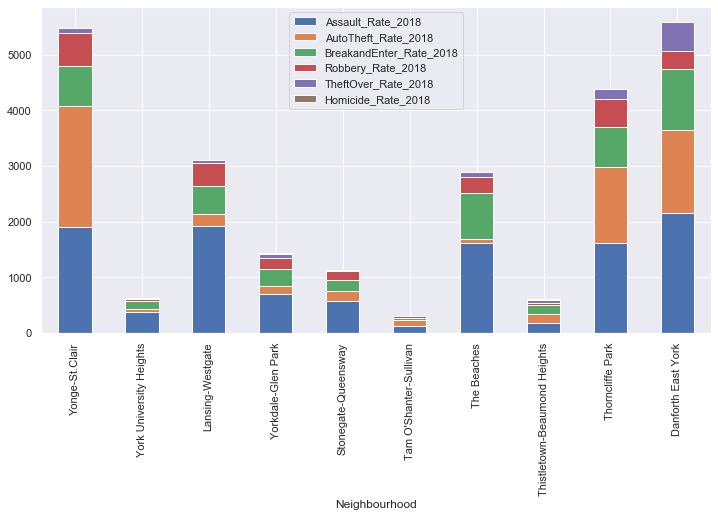

In [9]:
sns.set()
df_cr.head(10).set_index('Neighbourhood').plot(kind='bar', stacked=True, figsize=(12,6))

As seen, the type of crime varies among the 10 neighborhoods with the least crime. Some neighborhoods did not experience any homicides, while other have a relatively high number of homicides and less break and entries and auto theft (such as Willowdale East). Let's see where the top 5 neighborhoods are located on a map of Toronto.

In [10]:
# retrieve coordinates of Toronto
df = df_crime.head(5)
g = geocoder.arcgis('Toronto, Ontario')
latitude = g.lat
longitude = g.lng

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The neighborhoods all seem to be located along the same road, away from the city center.

## Results
We have found the neighborhoods that tend to have the lowest crime rates. If we continue with the 5 neighborhoods that have the least crime, we could see how many Japanese restaurants each of the neighborhoods has using Foursquare. Let's do that now.

In [11]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'

In [12]:
client = fs.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, version=VERSION)
top_nh = 5
query = 'japanese'
radius = 3000  # assuming people are willing to travel up to 3 km for a restaurant
limit = 100  # max number of results due to free license at Foursquare
top_neighborhoods = df_cr.Neighbourhood.head(top_nh).tolist()
df_res = pd.DataFrame()

for nh in range(top_nh):
    lat = str(df_crime.Latitude.iloc[nh])
    lon = str(df_crime.Longitude.iloc[nh])
    location = f"{lat},{lon}"
    df_temp = ft.venues_explore(client,lat=lat,lng=lon,radius=radius,limit=limit,query=query)    
    df_temp['Neighborhood'] = df_crime.Neighbourhood.iloc[nh]
    df_res = df_res.append(df_temp, ignore_index=True)

//anaconda3/envs/coursera/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
df_res.head()

,index,Address,Category,City,Country,Latitude,Longitude,Name,Neighborhood
0,0,108 Corporate Dr,Sushi Restaurant,Scarborough,Canada,43.780679,-79.247320,Fukuoka Sushi,Woburn
1,0,45 Milner Ave,Japanese Restaurant,Scarborough,Canada,43.783539,-79.253117,Teriyaki Experience,Woburn
2,0,"300 Borough Drive,Scarborough Town Centre",Japanese Restaurant,Scarborough,Canada,43.776046,-79.257036,Wasabi Grill and Noodle,Woburn
3,0,300 Borough Dr.,Sushi Restaurant,Toronto,Canada,43.776822,-79.258413,Mac Sushi,Woburn
4,0,1300 Don Mills Rd #2,Japanese Restaurant,North York,Canada,43.745494,-79.345821,Matsuda Japanese Cuisine & Teppanyaki,Banbury-Don Mills


In [14]:
df_res['Neighborhood'].value_counts()

Willowdale East         43
Banbury-Don Mills       14
Woburn                   4
Pelmo Park-Humberlea     4
Rouge                    1
Name: Neighborhood, dtype: int64

There are thus many Japanese restaurants in Willowdale East, while Rouge only has one.

## Discussion
As seen before, Rouge seems to be the best neighborhood to start a Japanese restaurant. This neighborhood has a (relatively) high population, low crime rate, and only 1 Japanese restaurant. Other good candidates could be Woburn and Pelmo Park-Humberlea, although these have a lower population and a higher crime rate, respectively. Willowdale East has the most Japanese restaurants. A quick Wikipedia search learns that this neighborhood has a high number of immigrants from Asia, and thus it is not surprising that there are so many Japanese/Asian restaurants compared to the other neighborhoods.

#### Enhancements
This analysis could be expanded by adding more data(sets), for example on the income per capita of neighborhoods, other types of restaurants, prices for real estate etc. In this way, the conclusion that Rouge is the best neighborhood could be further fortified or weakened.

#### Limitations
- Crime data might be underreported, incentive for police to understate crime
- Data could be outdated, not up-to-date
- Several assumptions have been made, these could be incorrect

## Conclusion
In this report researched was the best neighborhood in Toronto, Canada to start a Japanese restaurant. The best neighborhood would be the neightborhood that fulfilled the following 3 requirements: high population, low crime rate, and a lower number of (possibly competing) Japanese restaurants. The best neighborhood to start a Japanese restaurant in Rouge.